# Forecasting Consensus Expectations: Consumer Price Index

## Point + Directional + Distributional Forecasts

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import plotly.express as px

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
OUT_DIR = "../out"        
MOM_DF_FILE       = "cpi_mom_df.parquet"
MOM_DF_FULL_FILE  = "cpi_mom_df_full.parquet"
YOY_DF_FILE       = "cpi_yoy_df.parquet"
YOY_DF_FULL_FILE  = "cpi_yoy_df_full.parquet"

mom_df       = pd.read_parquet(os.path.join(OUT_DIR, MOM_DF_FILE),      engine="pyarrow")
mom_df_full  = pd.read_parquet(os.path.join(OUT_DIR, MOM_DF_FULL_FILE), engine="pyarrow")

yoy_df       = pd.read_parquet(os.path.join(OUT_DIR, YOY_DF_FILE),      engine="pyarrow")
yoy_df_full  = pd.read_parquet(os.path.join(OUT_DIR, YOY_DF_FULL_FILE), engine="pyarrow")

print("mom_df shape     :", mom_df.shape)
print("mom_df_full shape:", mom_df_full.shape)

print("yoy_df shape     :", yoy_df.shape)
print("yoy_df_full shape:", yoy_df_full.shape)

mom_df shape     : (57710, 11)
mom_df_full shape: (68150, 11)
yoy_df shape     : (39400, 11)
yoy_df_full shape: (46492, 11)


In [14]:
mom_df.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,0.2000,0.2000,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0000,Core CPI M/M
1,2006-01-18,2005-12-31,0.2000,0.2000,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,0.0000,Core CPI M/M
2,2006-01-18,2005-12-31,0.2000,0.2000,Alison Lynn Reaser,Point Loma Nazarene University,0.2000,2006-01-16,0.0000,0.0000,Core CPI M/M
3,2006-01-18,2005-12-31,0.2000,0.2000,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0000,Core CPI M/M
4,2006-01-18,2005-12-31,0.2000,0.2000,Andreas Busch,Bantleon AG,0.2000,2006-01-16,0.0000,0.0000,Core CPI M/M


In [15]:
yoy_df.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,2.2000,2.2000,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0000,Core CPI Y/Y
1,2006-01-18,2005-12-31,2.2000,2.2000,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0000,Core CPI Y/Y
2,2006-01-18,2005-12-31,2.2000,2.2000,Andreas Busch,Bantleon AG,NaN,NaT,NaN,0.0000,Core CPI Y/Y
3,2006-01-18,2005-12-31,2.2000,2.2000,Andrew Gretzinger,Manulife Asset Management Limited,NaN,NaT,NaN,0.0000,Core CPI Y/Y
4,2006-01-18,2005-12-31,2.2000,2.2000,Aneta Markowska,Moore Capital Management LP,NaN,NaT,NaN,0.0000,Core CPI Y/Y


In [3]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
# Helper:  count decimal places in a numeric Series
# ------------------------------------------------------------------
def count_decimals(series: pd.Series, max_scan: int = 1_000_000):
    """
    Return a value-counts Series telling you how many observations have
    0, 1, 2, … decimal places. NaNs are ignored.

    Parameters
    ----------
    series : pd.Series
        The numeric column to inspect.
    max_scan : int, optional
        Safety cap on how many rows to scan (defaults to 1 million).

    Examples
    --------
    >>> count_decimals(df['forecast'])
    0    378
    1    112
    2     45
    dtype: int64
    """
    # work on a copy of numeric values only
    vals = series.dropna().astype(float).to_numpy()[:max_scan]

    def decimals_of(x: float) -> int:
        # Convert to string, strip trailing zeros and the dot itself
        s = format(x, ".10f").rstrip("0").rstrip(".")
        return len(s.partition(".")[2])

    dec_counts = pd.Series([decimals_of(v) for v in vals]).value_counts().sort_index()
    dec_counts.index.name = "# decimal places"
    dec_counts.name = "count"
    return dec_counts

# ------------------------------------------------------------------
# Run on each CPI dataframe / column you care about
# ------------------------------------------------------------------
PANELS = {
    "Core CPI M/M  – forecast"      : mom_df["forecast"],
    "Core CPI M/M  – median_survey" : mom_df["median_survey"],
    "Core CPI Y/Y  – forecast"      : yoy_df["forecast"],
    "Core CPI Y/Y  – median_survey" : yoy_df["median_survey"],
}

for label, col in PANELS.items():
    print(f"\n{label}")
    print(count_decimals(col))



Core CPI M/M  – forecast
# decimal places
0      343
1    12955
2      401
3       81
4       13
5        1
Name: count, dtype: int64

Core CPI M/M  – median_survey
# decimal places
1    56550
2     1160
Name: count, dtype: int64

Core CPI Y/Y  – forecast
# decimal places
0     668
1    6474
2      70
3      48
4      11
Name: count, dtype: int64

Core CPI Y/Y  – median_survey
# decimal places
0     3349
1    34869
2      591
3      394
Name: count, dtype: int64


In [4]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# helper: how many decimals does a single number have?
# ------------------------------------------------------------
def _decimals(x: float) -> int:
    """
    Return the number of digits after the decimal point for *one* float.
    NaNs → -1  (so they never match our >=4 filter)
    """
    if pd.isna(x):
        return -1
    s = format(float(x), ".10f").rstrip("0").rstrip(".")
    return len(s.partition(".")[2])

# ------------------------------------------------------------
# main inspection function
# ------------------------------------------------------------
def show_high_precision(df: pd.DataFrame,
                        col: str = "forecast",
                        min_decimals: int = 4):
    """
    Display all rows where `col` has ≥ `min_decimals` decimal places.

    Parameters
    ----------
    df : pd.DataFrame
    col : str
        Name of the numeric column to inspect (default "forecast").
    min_decimals : int
        Threshold of decimal places to flag (default 4).

    Returns
    -------
    pd.DataFrame
        The filtered rows, ready for further inspection.
    """
    mask = df[col].apply(_decimals) >= min_decimals
    flagged = df.loc[mask].copy()

    print(f"→ {len(flagged)} rows in '{col}' with ≥ {min_decimals} decimals\n")
    display_cols = ["release_date", "economist", "firm", col, "asof"]
    display(flagged[display_cols].sort_values("release_date").head(20))  # show first 20
    return flagged

# ------------------------------------------------------------
# EXAMPLE USAGE
# ------------------------------------------------------------
# For Core CPI M/M:
high_prec_mom = show_high_precision(mom_df)

# For Core CPI Y/Y:
high_prec_yoy = show_high_precision(yoy_df)


→ 14 rows in 'forecast' with ≥ 4 decimals



,release_date,economist,firm,forecast,asof
39579,2017-05-12,Kevin Cummins,Natwest Markets,0.22111,2017-05-08
53770,2024-06-12,John D Herrmann,Herrmann Forecasting LLC,0.25910,2024-06-12
54060,2024-07-11,John D Herrmann,Herrmann Forecasting LLC,0.18920,2024-07-10
54350,2024-08-14,John D Herrmann,Herrmann Forecasting LLC,0.18880,2024-08-14
54640,2024-09-11,John D Herrmann,Herrmann Forecasting LLC,0.24740,2024-09-11
54930,2024-10-10,John D Herrmann,Herrmann Forecasting LLC,0.23050,2024-10-09
55220,2024-11-13,John D Herrmann,Herrmann Forecasting LLC,0.22980,2024-11-13
55510,2024-12-11,John D Herrmann,Herrmann Forecasting LLC,0.26050,2024-12-10
55800,2025-01-15,John D Herrmann,Herrmann Forecasting LLC,0.27120,2025-01-14
56090,2025-02-12,John D Herrmann,Herrmann Forecasting LLC,0.30370,2025-02-11


→ 11 rows in 'forecast' with ≥ 4 decimals



,release_date,economist,firm,forecast,asof
36530,2024-06-12,John D Herrmann,Herrmann Forecasting LLC,3.5102,2024-06-12
36727,2024-07-11,John D Herrmann,Herrmann Forecasting LLC,3.4054,2024-07-10
36924,2024-08-14,John D Herrmann,Herrmann Forecasting LLC,3.2375,2024-08-14
37318,2024-10-10,John D Herrmann,Herrmann Forecasting LLC,3.1744,2024-10-09
37712,2024-12-11,John D Herrmann,Herrmann Forecasting LLC,3.2512,2024-12-10
37909,2025-01-15,John D Herrmann,Herrmann Forecasting LLC,3.2959,2025-01-14
38106,2025-02-12,John D Herrmann,Herrmann Forecasting LLC,3.1571,2025-02-11
38303,2025-03-12,John D Herrmann,Herrmann Forecasting LLC,3.2112,2025-03-11
38500,2025-04-10,John D Herrmann,Herrmann Forecasting LLC,3.1165,2025-04-09
38697,2025-05-13,John D Herrmann,Herrmann Forecasting LLC,2.9065,2025-05-12


## Static inverse-MSE

In [16]:
# ───────────────────────── settings ────────────────────────────
import numpy as np, pandas as pd
from itertools import product
from scipy import stats
from tqdm.auto import tqdm

contiguity_windows = [3, 6, 12, 24]                # rolling-window lengths
methods            = ["inverse_mse", "inverse_mae", "equal_weight"]
ridge              = 1e-6                          # stabiliser for inverse weights
start_date_eval    = "2010-01-01"                  # optional back-test start
# ───────────────────────────────────────────────────────────────

def run_static_panel(df_panel: pd.DataFrame, name: str):
    """
    Replicates the NFP static-weight grid search:
      • df_panel must have release_date / economist / forecast / actual / median_survey / error
      • returns (eval_rows_df, live_rows_df)
    """
    # trim evaluation period if desired
    df_panel = df_panel[df_panel["release_date"] >= start_date_eval].copy()

    dates = np.sort(df_panel["release_date"].unique())
    eval_rows, live_rows = [], []

    for window, method in tqdm(product(contiguity_windows, methods),
                               total=len(contiguity_windows)*len(methods),
                               desc=f"{name} grid"):

        preds = []                    # per-release records

        for idx in range(window, len(dates)):
            t = dates[idx]

            # ----- look-back slice -----
            hist = df_panel[df_panel["release_date"].isin(dates[idx-window:idx])]

            # economists with ALL forecasts inside window
            econs = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            econs = econs[econs].index
            if econs.empty:
                continue

            # ----- compute weights -----
            if method == "equal_weight":
                w = pd.Series(1.0, index=econs)

            else:
                grp = hist[hist["economist"].isin(econs)].groupby("economist")["error"]
                score = grp.apply(lambda s:
                                  np.nanmean(s**2) if method == "inverse_mse"
                                  else np.nanmean(np.abs(s)))
                w = 1.0/(score + ridge)

            w /= w.sum()

            # ----- current forecasts -----
            cur = df_panel[(df_panel["release_date"] == t) &
                           (df_panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()

            smart   = np.dot(w, f_t.loc[w.index])
            median  = df_panel.loc[df_panel["release_date"] == t,
                                   "median_survey"].iloc[0]
            actual  = df_panel.loc[df_panel["release_date"] == t,
                                   "actual"].iloc[0]

            preds.append((t, smart, median, actual))

        # nothing produced for this spec?
        if not preds:
            continue

        oos = pd.DataFrame(preds, columns=["date", "smart", "median", "actual"])

        # unreleased print (latest actual NaN) → stash live forecast
        unreleased = oos[oos["actual"].isna()]
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            live_rows.append({"panel" : name,
                              "window": window,
                              "method": method,
                              "date"  : last["date"],
                              "smart" : last["smart"],
                              "median": last["median"],
                              "pred_dir": int(last["smart"] > last["median"]) })

        # evaluation on realised months only
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:
            continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)
        eval_df["pred_dir"]   = (eval_df["smart"]  > eval_df["median"]).astype(int)

        obs         = len(eval_df)
        rmse_smart  = np.sqrt((eval_df["smart_err"]**2 ).mean())
        rmse_median = np.sqrt((eval_df["median_err"]**2).mean())

        d       = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_stat = d.mean()/d.std(ddof=1)*np.sqrt(obs)
        dm_p    = 2*(1-stats.norm.cdf(abs(dm_stat)))

        hits     = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
        p1, p2   = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_stat  = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
        pt_p     = 2*(1-stats.norm.cdf(abs(pt_stat)))

        eval_rows.append({"panel":name,"window":window,"method":method,
                          "obs":obs,"RMSE_smart":rmse_smart,"RMSE_median":rmse_median,
                          "HitRate":hit_rate,"Binom_p":binom_p,"PT_p":pt_p,"DM_p":dm_p})
    return pd.DataFrame(eval_rows), pd.DataFrame(live_rows)


# ────────────────────────── run panels ─────────────────────────
PANELS_COVID = {                     # “COVID-trimmed” set (match your mom_df / yoy_df)
    "Core CPI M/M": mom_df,
    "Core CPI Y/Y": yoy_df,
}
PANELS_FULL  = {                     # Full history
    "Core CPI M/M": mom_df_full,
    "Core CPI Y/Y": yoy_df_full,
}

res_covid, live_covid = [], []
for name, df in PANELS_COVID.items():
    e, l = run_static_panel(df.copy(), name)
    res_covid.append(e);  live_covid.append(l)
res_covid = pd.concat(res_covid, ignore_index=True)
live_covid = pd.concat(live_covid, ignore_index=True)

res_full, live_full = [], []
for name, df in PANELS_FULL.items():
    e, l = run_static_panel(df.copy(), name + " (Full)")
    res_full.append(e);   live_full.append(l)
res_full  = pd.concat(res_full,  ignore_index=True)
live_full = pd.concat(live_full, ignore_index=True)


# ───── robust-winner pick for each COVID panel (same logic) ────
def choose_winner(df_eval: pd.DataFrame, panel_name: str):
    sub = df_eval[df_eval["panel"] == panel_name]
    robust = sub[(sub["DM_p"]<0.10)&(sub["Binom_p"]<0.10)&(sub["PT_p"]<0.10)]
    winner = robust.loc[robust["RMSE_smart"].idxmin()] if not robust.empty \
             else sub.loc[sub["RMSE_smart"].idxmin()]
    return winner

winners = {p: choose_winner(res_covid, p) for p in PANELS_COVID.keys()}

# ──────────────────────────── PRINTS ───────────────────────────
pd.set_option("display.float_format", "{:.4f}".format)

print("\n=== COVID-filtered panel (historical) ===")
for p in PANELS_COVID.keys():
    print(f"\n--- {p} ---")
    print(res_covid[res_covid["panel"] == p]
          .sort_values(["window","method"])
          .to_string(index=False))

print("\n=== Full panel (historical) ===")
for p in PANELS_FULL.keys():
    print(f"\n--- {p} ---")
    print(res_full[res_full["panel"] == p+" (Full)"]
          .sort_values(["window","method"])
          .to_string(index=False))

# ---------- live forecasts (COVID set) ----------
if live_covid.empty:
    print("\nNo unreleased CPI prints – all actuals available.")
else:
    print("\n=== LIVE FORECASTS (COVID-filtered data) ===")
    for p, win_row in winners.items():
        w, m = int(win_row["window"]), win_row["method"]
        live_rows = live_covid[(live_covid["panel"] == p) &
                               (live_covid["method"] == m)].sort_values("window")
        if live_rows.empty:
            continue
        print(f"\n>>> {p}   •   method = {m}")
        for _, row in live_rows.iterrows():
            direction = "Higher-than-median" if row["pred_dir"] else "Lower-than-median"
            print(f"[{int(row['window']):2d}-mo]  Date: {pd.to_datetime(row['date']).date()}  |  "
                  f"Smart: {row['smart']:.4f}  |  Median: {row['median']:.4f}  |  Signal: {direction}")


Core CPI M/M grid:   0%|          | 0/12 [00:00<?, ?it/s]

Core CPI Y/Y grid:   0%|          | 0/12 [00:00<?, ?it/s]

Core CPI M/M (Full) grid:   0%|          | 0/12 [00:00<?, ?it/s]

Core CPI Y/Y (Full) grid:   0%|          | 0/12 [00:00<?, ?it/s]


=== COVID-filtered panel (historical) ===

--- Core CPI M/M ---
       panel  window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p   PT_p   DM_p
Core CPI M/M       3 equal_weight  147      0.0798       0.0836   0.7415   0.0000 0.0001 0.0421
Core CPI M/M       3  inverse_mae  147      0.0830       0.0836   0.7279   0.0000 0.0000 0.8565
Core CPI M/M       3  inverse_mse  147      0.0828       0.0836   0.7211   0.0000 0.0001 0.8017
Core CPI M/M       6 equal_weight  144      0.0799       0.0836   0.7431   0.0000 0.0001 0.0549
Core CPI M/M       6  inverse_mae  144      0.0799       0.0836   0.7222   0.0000 0.0006 0.0628
Core CPI M/M       6  inverse_mse  144      0.0794       0.0836   0.7222   0.0000 0.0006 0.0324
Core CPI M/M      12 equal_weight  138      0.0796       0.0837   0.7174   0.0000 0.0004 0.0410
Core CPI M/M      12  inverse_mae  138      0.0793       0.0837   0.7391   0.0000 0.0000 0.0304
Core CPI M/M      12  inverse_mse  138      0.0793       0.0837   0.731

In [ ]:
# ================================================================
#  A ▸ Single-model grid search:  Win ∈ {3,6,12}  ×  Method ∈ {equal, inv_MSE, inv_MAE, EWMA-inv_MSE}
#      → back-test (releases ≥ 2010-01-01)  →  RMSE & directional hit-rate
# ================================================================
import numpy as np, pandas as pd
from tqdm.auto import tqdm
from itertools import product
from scipy import stats

# --------------------- tune here ---------------------
WINDOWS      = [3, 6, 12]
METHODS      = ["equal", "inverse_mse", "inverse_mae", "ewma_inv_mse"]
EWMA_LAMBDA  = 0.90
RIDGE        = 1e-6
START_DATE   = "2010-01-01"

PANELS = {
    "Core CPI M/M": mom_df_full.copy(),
    "Core CPI Y/Y": yoy_df_full.copy(),
}
# -----------------------------------------------------

def build_weights(hist, method):
    """Return pd.Series(weights) indexed by economist."""
    if method == "equal":
        w = pd.Series(1.0, index=hist["economist"].unique())
    else:
        # error vector
        err_tbl = (hist.groupby("economist")["error"]
                         .apply(lambda s: np.nan_to_num(s.values, nan=0.0)))
        if method == "ewma_inv_mse":
            n = len(hist["release_date"].unique())
            ew = EWMA_LAMBDA ** np.arange(n-1, -1, -1);  ew /= ew.sum()
            mse = err_tbl.apply(lambda e: np.dot(ew[-len(e):], e**2))
        elif method == "inverse_mse":
            mse = err_tbl.apply(lambda e: np.mean(e**2))
        else:  # inverse_mae
            mse = err_tbl.apply(lambda e: np.mean(np.abs(e)))
        w = 1.0 / (mse + RIDGE)
    return w / w.sum()

results = []

for panel_name, df_full in PANELS.items():
    df_full = df_full[df_full["release_date"] >= START_DATE].copy()
    dates   = np.sort(df_full["release_date"].unique())

    for W, meth in tqdm(product(WINDOWS, METHODS),
                        total=len(WINDOWS)*len(METHODS),
                        desc=f"{panel_name}  specs"):

        records = []           # per-release rows

        for idx in range(W, len(dates)):
            t = dates[idx]
            # look-back window
            hist = df_full[df_full["release_date"]
                           .between(dates[idx-W], dates[idx-1])]
            # economists with complete coverage
            elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            econs = elig[elig].index
            if econs.empty:  continue

            w = build_weights(hist[hist["economist"].isin(econs)], meth)

            # current forecasts
            cur = df_full[(df_full["release_date"] == t) &
                          (df_full["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:  continue
            w /= w.sum()

            smart   = np.dot(w, f_t.loc[w.index])
            median  = df_full.loc[df_full["release_date"] == t,
                                  "median_survey"].iloc[0]
            actual  = df_full.loc[df_full["release_date"] == t,
                                  "actual"].iloc[0]

            if np.isnan(actual):        # skip unreleased print
                continue
            records.append((smart, median, actual))

        # ------------- aggregate metrics -------------
        if not records:  continue
        rec = pd.DataFrame(records, columns=["smart","median","actual"])
        rec["smart_err"]  = rec["smart"]  - rec["actual"]
        rec["median_err"] = rec["median"] - rec["actual"]
        rec["hit"]        = (np.sign(rec["smart"]-rec["median"]) ==
                             np.sign(rec["actual"]-rec["median"])).astype(int)

        results.append({
            "Panel"       : panel_name,
            "Window"      : W,
            "Method"      : meth,
            "Obs"         : len(rec),
            "RMSE_smart"  : np.sqrt(np.mean(rec["smart_err"]**2)),
            "RMSE_median" : np.sqrt(np.mean(rec["median_err"]**2)),
            "HitRate"     : rec["hit"].mean()
        })

# ---------- display ----------
tbl = (pd.DataFrame(results)
       .sort_values(["Panel","Window","Method"])
       .reset_index(drop=True))
pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Single-method back-test results (≥2010 releases) ===")
display(tbl)


Core CPI M/M  specs:   0%|          | 0/12 [00:00<?, ?it/s]

Core CPI Y/Y  specs:   0%|          | 0/12 [00:00<?, ?it/s]


=== Single-method back-test results (≥2010 releases) ===


,Panel,Window,Method,Obs,RMSE_smart,RMSE_median,HitRate
0,Core CPI M/M,3,equal,183,0.1154,0.1186,0.4699
1,Core CPI M/M,3,ewma_inv_mse,183,0.1150,0.1186,0.4645
2,Core CPI M/M,3,inverse_mae,183,0.1154,0.1186,0.4645
3,Core CPI M/M,3,inverse_mse,183,0.1150,0.1186,0.4590
4,Core CPI M/M,6,equal,180,0.1159,0.1191,0.4722
5,Core CPI M/M,6,ewma_inv_mse,180,0.1136,0.1191,0.4389
6,Core CPI M/M,6,inverse_mae,180,0.1147,0.1191,0.4500
7,Core CPI M/M,6,inverse_mse,180,0.1136,0.1191,0.4389
8,Core CPI M/M,12,equal,174,0.1158,0.1202,0.4540
9,Core CPI M/M,12,ewma_inv_mse,174,0.1140,0.1202,0.4540


In [7]:
# ================================================================
#  B ▸ Robust-vote ensembles – all 3-model combinations
#      (base models = 12 specs from part A)
#      → back-test ≥2010  →  rank by directional hit-rate (top 3)
# ================================================================
import numpy as np, pandas as pd
from itertools import combinations, product
from tqdm.auto import tqdm

# --------------- reuse CONFIG from cell A ----------------
BASE_SPECS = [(w, m) for w in WINDOWS for m in METHODS]   # 12 tuples

def smart_forecast(df_full, W, method, date_idx_cache):
    """Return dict {date: smart_forecast} for one (W,method)."""
    preds = {}
    dates = date_idx_cache["dates"]
    for idx in range(W, len(dates)):
        t = dates[idx]
        hist = df_full[df_full["release_date"]
                       .between(dates[idx-W], dates[idx-1])]
        elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = elig[elig].index
        if econs.empty:  continue
        w = build_weights(hist[hist["economist"].isin(econs)], method)
        cur = df_full[(df_full["release_date"] == t) &
                      (df_full["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:      continue
        w /= w.sum()
        preds[t] = np.dot(w, f_t.loc[w.index])
    return preds

ensemble_rows = []

for panel_name, df_full in PANELS.items():
    df_full = df_full[df_full["release_date"] >= START_DATE].copy()
    dates   = np.sort(df_full["release_date"].unique())
    date_idx_cache = {"dates": dates}

    # pre-compute all 12 base-model series once
    base_model_preds = {}
    for W, m in tqdm(BASE_SPECS, desc=f"{panel_name} – precompute"):
        base_model_preds[(W, m)] = smart_forecast(df_full, W, m, date_idx_cache)

    # iterate 3-model combos
    for combo in tqdm(list(combinations(BASE_SPECS, 3)),
                      desc=f"{panel_name} combos"):

        hits, smart_sq, median_sq, n = 0, 0.0, 0.0, 0

        # intersection of dates where **all three** model forecasts exist
        common_dates = set.intersection(*[set(base_model_preds[c].keys())
                                          for c in combo])

        for t in common_dates:
            smart_vals = np.array([base_model_preds[c][t] for c in combo])
            smart_ens  = smart_vals.mean()          # ensemble point forecast
            median_t   = df_full.loc[df_full["release_date"] == t,
                                     "median_survey"].iloc[0]
            actual_t   = df_full.loc[df_full["release_date"] == t,
                                     "actual"].iloc[0]
            if np.isnan(actual_t):   continue

            hit = int(np.sign(smart_ens - median_t) ==
                      np.sign(actual_t - median_t))
            hits      += hit
            smart_sq  += (smart_ens  - actual_t)**2
            median_sq += (median_t - actual_t)**2
            n         += 1

        if n == 0:  continue
        ensemble_rows.append({
            "Panel"      : panel_name,
            "Combo"      : combo,
            "Obs"        : n,
            "HitRate"    : hits / n,
            "RMSE_smart" : np.sqrt(smart_sq / n),
            "RMSE_median": np.sqrt(median_sq / n)
        })

# -------- rank & show top-3 per panel --------
ens_tbl = pd.DataFrame(ensemble_rows)
top_tbl = (ens_tbl
           .sort_values(["Panel","HitRate","RMSE_smart"],
                         ascending=[True, False, True])
           .groupby("Panel")
           .head(3)
           .reset_index(drop=True))

pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Top-3 robust-vote ensembles (hit-rate ranked) ===")
display(top_tbl)


Core CPI M/M – precompute:   0%|          | 0/12 [00:00<?, ?it/s]

Core CPI M/M combos:   0%|          | 0/220 [00:00<?, ?it/s]

Core CPI Y/Y – precompute:   0%|          | 0/12 [00:00<?, ?it/s]

Core CPI Y/Y combos:   0%|          | 0/220 [00:00<?, ?it/s]


=== Top-3 robust-vote ensembles (hit-rate ranked) ===


,Panel,Combo,Obs,HitRate,RMSE_smart,RMSE_median
0,Core CPI M/M,"((3, equal), (3, inverse_mae), (3, ewma_inv_mse))",183,0.4699,0.1145,0.1186
1,Core CPI M/M,"((3, equal), (3, ewma_inv_mse), (6, equal))",180,0.4667,0.1149,0.1191
2,Core CPI M/M,"((3, equal), (3, inverse_mse), (6, equal))",180,0.4667,0.1150,0.1191
3,Core CPI Y/Y,"((3, equal), (3, inverse_mse), (3, ewma_inv_mse))",183,0.4262,0.1224,0.1256
4,Core CPI Y/Y,"((3, equal), (3, inverse_mae), (3, ewma_inv_mse))",183,0.4262,0.1226,0.1256
5,Core CPI Y/Y,"((3, equal), (3, inverse_mse), (3, inverse_mae))",183,0.4262,0.1226,0.1256


In [13]:
# %%---------------------------------------------------------------------------
# Inverse-MSE live forecast for the 2025-07-15 CPI print
#   • windows = {3, 6, 12} months (i.e. most-recent N releases)
#   • panels   = Core CPI M/M and Core CPI Y/Y  (mom_df_full / yoy_df_full)
# ---------------------------------------------------------------------------

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

EPS = 1e-8  # safety term when an economist has zero MSE

def inverse_mse_point(df_full: pd.DataFrame, live_date: pd.Timestamp,
                      window: int) -> float:
    """
    Rolling inverse-MSE ensemble for one release date.
    df_full must contain columns: release_date, economist, forecast, actual.
    """
    # last <window> historical releases (with actual values)
    past_dates = (df_full.loc[df_full["release_date"] < live_date, "release_date"]
                          .drop_duplicates()
                          .sort_values())[-window:]

    past = df_full[df_full["release_date"].isin(past_dates) & df_full["actual"].notna()]
    if past.empty:
        return np.nan

    # per-economist MSE
    mse = past.groupby("economist").apply(
            lambda g: np.mean((g["forecast"] - g["actual"])**2)
          )

    # weights ∝ 1 / MSE
    w = (1 / (mse + EPS)).rename("weight")
    w = w / w.sum()

    # blend current forecasts
    cur = df_full[df_full["release_date"] == live_date].merge(
            w, left_on="economist", right_index=True, how="inner"
          )
    return np.nan if cur.empty else np.sum(cur["forecast"] * cur["weight"])


def run_panel(df_full: pd.DataFrame, panel_name: str,
              live_date=pd.Timestamp("2025-07-15")):
    print(f"\n=== {panel_name} ===")

    # crowd median for live date (single number in the file)
    crowd_med = (df_full[df_full["release_date"] == live_date]
                 .iloc[0]["median_survey"])

    for win in (3, 6, 12):
        point = inverse_mse_point(df_full, live_date, win)

        if pd.isna(point):
            print(f"  {win:>2}-mo window → insufficient history")
            continue

        direction = ("Higher-than-median" if point > crowd_med
                     else "Lower-than-median" if point < crowd_med
                     else "Equal-to-median")

        print(f"  {win:>2}-mo inverse-MSE:")
        print(f"     Point     : {point:7.4f}")
        print(f"     Direction : {direction}")

# --------------------------------------------------------------------------- #
PANELS = {
    "Core CPI M/M": mom_df_full,
    "Core CPI Y/Y": yoy_df_full
}

for name, df_full in PANELS.items():
    run_panel(df_full.copy(), name)



=== Core CPI M/M ===
   3-mo inverse-MSE:
     Point     :  0.1746
     Direction : Lower-than-median
   6-mo inverse-MSE:
     Point     :  0.1849
     Direction : Lower-than-median
  12-mo inverse-MSE:
     Point     :  0.1646
     Direction : Lower-than-median

=== Core CPI Y/Y ===
   3-mo inverse-MSE:
     Point     :  2.3458
     Direction : Lower-than-median
   6-mo inverse-MSE:
     Point     :  2.1418
     Direction : Lower-than-median
  12-mo inverse-MSE:
     Point     :  0.0001
     Direction : Lower-than-median



=== Core CPI M/M ===


  0%|          | 0/151 [00:00<?, ?it/s]

Back-test releases    : 150
RMSE  smart forecast  : 0.1247
RMSE  crowd median    : 0.1271
Directional hit-rate  : 0.433

🔮  Live forecast for 2025-07-15:
     Point  : 0.2620
     Median : 0.3000
     Signal : Lower-than-median


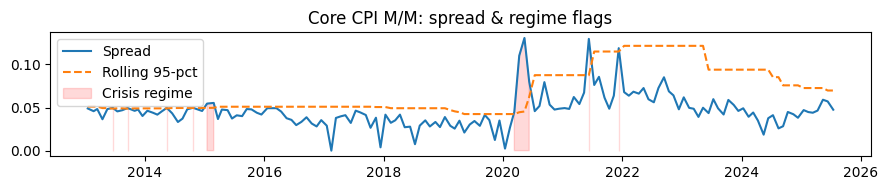


=== Core CPI Y/Y ===


  0%|          | 0/152 [00:00<?, ?it/s]

Back-test releases    : 150
RMSE  smart forecast  : 0.1287
RMSE  crowd median    : 0.1348
Directional hit-rate  : 0.387

🔮  Live forecast for 2025-07-15:
     Point  : 2.9525
     Median : 2.9545
     Signal : Lower-than-median


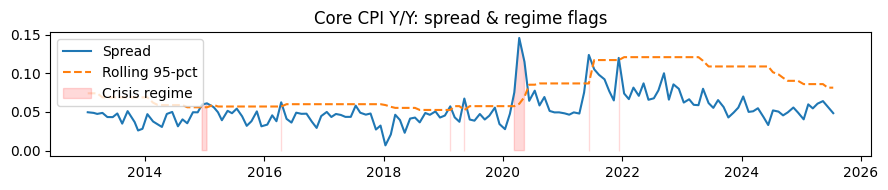

In [9]:
# %% [markdown]
# Trim-Winsorise + Regime-Switch Ensemble  (robust version – warnings silenced)
# -----------------------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from tqdm.auto import tqdm

# ---------- parameters ----------
LOOKBACK_W   = 12          # months for inverse-MSE weighting
ROLL_SPREAD  = 36          # months for 95-pct spread threshold
TRIM_P       = 0.05        # winsorise limits
RIDGE        = 1e-6        # stabiliser for 0-division
START_DATE   = "2010-01-01"

PANELS = {
    "Core CPI M/M": {"df": mom_df, "df_full": mom_df_full},
    "Core CPI Y/Y": {"df": yoy_df,  "df_full": yoy_df_full},
}

def winsorise(series, p=TRIM_P):
    """5-95 % winsorisation (handles <2 obs gracefully)."""
    if series.size < 2:
        return series.copy()
    lo, hi = series.quantile([p, 1-p])
    return series.clip(lo, hi)

def calc_spread(group):
    """Cross-section std of trimmed forecasts; returns NaN if <3 obs."""
    x = winsorise(group["forecast"].dropna())
    return x.std(ddof=0) if x.size >= 3 else np.nan

def inverse_mse_weights(hist_df, economists):
    """Inverse-MSE weights over LOOKBACK_W window (trimmed)."""
    if hist_df.empty:
        return pd.Series(dtype=float)

    # trim & compute squared errors
    hist_df = hist_df.dropna(subset=["forecast", "actual"])
    hist_df["f_trim"] = winsorise(hist_df["forecast"])
    sq_err = (hist_df["f_trim"] - hist_df["actual"]) ** 2

    mse = sq_err.groupby(hist_df["economist"]).mean()
    w = 1.0 / (mse + RIDGE)
    w = w.reindex(economists).fillna(0.0)
    return w / w.sum() if w.sum() > 0 else pd.Series(dtype=float)

def backtest_one_panel(panel_df):
    df = panel_df.copy()
    df = df[df["release_date"] >= START_DATE]

    dates = np.sort(df["release_date"].unique())
    records, regime_log = [], []

    for idx in tqdm(range(ROLL_SPREAD, len(dates)), leave=False):
        t_date = dates[idx]
        cur    = df[df["release_date"] == t_date].dropna(subset=["forecast"])

        # skip releases with <3 forecasts
        if cur.shape[0] < 3:
            continue

        # ---------- regime classification ----------
        hist_window = dates[idx-ROLL_SPREAD:idx]
        hist = df[df["release_date"].isin(hist_window)]
        hist_spread = (hist.groupby("release_date", sort=False)
                            .apply(calc_spread).dropna())
        spread_q95 = np.nanpercentile(hist_spread, 95) if len(hist_spread) else np.nan

        cur_spread = winsorise(cur["forecast"]).std(ddof=0)
        crisis = cur_spread > spread_q95 if not np.isnan(spread_q95) else False
        regime_log.append((t_date, cur_spread, spread_q95, crisis))

        # ---------- weighting ----------
        if crisis:
            w = pd.Series(1.0, index=cur["economist"]) / cur.shape[0]   # equal-weight
        else:
            lookback_dates = dates[max(0, idx-LOOKBACK_W):idx]
            hist12 = df[df["release_date"].isin(lookback_dates)]
            w = inverse_mse_weights(hist12, cur["economist"])
            if w.empty:                         # fallback if no valid history
                w = pd.Series(1.0, index=cur["economist"]) / cur.shape[0]

        # ---------- aggregate ----------
        cur["f_trim"] = winsorise(cur["forecast"])
        point  = np.dot(w.values, cur["f_trim"])
        median = cur["forecast"].median()
        actual = cur["actual"].iloc[0]          # may be NaN for unreleased print

        records.append((t_date, point, median, actual))

    bt = (pd.DataFrame(records, columns=["date","smart","median","actual"])
            .sort_values("date").reset_index(drop=True))

    realised = bt.dropna(subset=["actual"])
    if realised.empty:        # prevent division by 0
        rmse_s = rmse_m = hit = np.nan
    else:
        rmse_s = np.sqrt(((realised["smart"]  - realised["actual"])**2).mean())
        rmse_m = np.sqrt(((realised["median"] - realised["actual"])**2).mean())
        hit    = (np.sign(realised["smart"] - realised["median"])
                  == np.sign(realised["actual"] - realised["median"])).mean()

    pending = bt[bt["actual"].isna()].tail(1)
    regime_df = pd.DataFrame(regime_log,
                             columns=["date","spread","q95","crisis"])

    return bt, (rmse_s, rmse_m, hit), pending, regime_df

# ---------------- run & print ----------------
warnings.filterwarnings("ignore")      # silence pandas & runtime warnings
for label, d in PANELS.items():
    print(f"\n=== {label} ===")
    bt, (rmse_s, rmse_m, hit), pending, reg = backtest_one_panel(d["df_full"])

    n_obs = bt["actual"].notna().sum()
    print(f"Back-test releases    : {n_obs}")
    print(f"RMSE  smart forecast  : {rmse_s:.4f}")
    print(f"RMSE  crowd median    : {rmse_m:.4f}")
    print(f"Directional hit-rate  : {hit:.3f}")

    if not pending.empty:
        row = pending.iloc[0]
        dir_sig = ("Higher" if row["smart"] > row["median"] else "Lower") + "-than-median"
        print(f"\n🔮  Live forecast for {row['date'].date()}:")
        print(f"     Point  : {row['smart']:.4f}")
        print(f"     Median : {row['median']:.4f}")
        print(f"     Signal : {dir_sig}")

    # quick regime plot
    plt.figure(figsize=(9,2))
    plt.plot(reg["date"], reg["spread"], label="Spread")
    plt.plot(reg["date"], reg["q95"], "--", label="Rolling 95-pct")
    plt.fill_between(reg["date"], 0, reg["spread"], where=reg["crisis"],
                     alpha=.15, color="red", label="Crisis regime")
    plt.title(f"{label}: spread & regime flags"); plt.legend(); plt.tight_layout()
    plt.show()


In [11]:
# %% Kalman filter CPI forecast ------------------------------------------------
import os, numpy as np, pandas as pd
from tqdm.auto import tqdm
from scipy.stats.mstats import winsorize
from datetime import datetime

# --------------------------------------------------------------------------- #
# 1 )  parameters you might tweak
# --------------------------------------------------------------------------- #
TRAIN_START = "2010-01-01"     # start of back-test window
INIT_TRAIN  = "2012-12-31"     # last release used for initial q,r calibration
TRIM_P      = 0.10             # trim 10 % in each tail when building smart fcst

# --------------------------------------------------------------------------- #
# 2 )  helper fns
# --------------------------------------------------------------------------- #
def winsorise(a, trim_p=TRIM_P):
    return winsorize(a, limits=[trim_p, trim_p])

def smart_forecast(df_panel):
    """Return trimmed-mean forecast for every release date in the panel."""
    smart = (df_panel
             .groupby("release_date")
             .apply(lambda g: winsorise(g["forecast"]).mean())
             .rename("smart"))
    return smart

def kalman_filter(series_act, series_obs, q, r):
    """
    Run a 1-dimensional RW-observation Kalman filter.
    Returns pd.Series of posterior means (our forecast for the *actual*).
    """
    idx = series_obs.index
    x_hat = pd.Series(index=idx, dtype=float)  # posterior mean
    P     = q                                  # initial state variance
    x_prev = series_act.loc[idx[0]]            # initialise at first *actual*
    
    for t in idx:
        # prediction
        x_pred = x_prev
        P_pred = P + q

        # update   (skip if measurement missing)
        y_t = series_obs.loc[t]
        if pd.notna(y_t):
            K      = P_pred / (P_pred + r)     # Kalman gain
            x_upd  = x_pred + K * (y_t - x_pred)
            P      = (1 - K) * P_pred
        else:                                  # no measurement
            x_upd  = x_pred
            P      = P_pred

        x_hat.loc[t] = x_upd
        x_prev       = x_upd

    return x_hat

def evaluate(pred, actual, median):
    err  = pred - actual
    rmse = np.sqrt(np.nanmean(err**2))
    rmse_med = np.sqrt(np.nanmean((median - actual)**2))
    hit  = np.nanmean(np.sign(pred - median) == np.sign(actual - median))
    return rmse, rmse_med, hit

# --------------------------------------------------------------------------- #
# 3 )  run for both panels
# --------------------------------------------------------------------------- #
PANELS = {
    "Core CPI M/M": {"df": mom_df, "df_full": mom_df_full},
    "Core CPI Y/Y": {"df": yoy_df, "df_full": yoy_df_full},
}

for name, d in PANELS.items():
    print(f"\n=== {name} ===")

    df_full = d["df_full"].copy()
    df_full = df_full[df_full["release_date"] >= TRAIN_START].sort_values("release_date")

    # build smart forecast & crowd median by release date
    smart = smart_forecast(df_full)
    median = (df_full.groupby("release_date")["median_survey"].first())

    # actual series
    actual = df_full.drop_duplicates("release_date").set_index("release_date")["actual"]

    # --------------------------------------------------------------------- #
    # initial q, r from the *calibration window* (up to INIT_TRAIN)
    cal_mask = actual.index <= INIT_TRAIN
    q = np.nanvar(actual.diff().loc[cal_mask].dropna(), ddof=0)
    r = np.nanvar((smart - actual).loc[cal_mask],             ddof=0)

    # --------------------------------------------------------------------- #
    # Kalman walk-forward
    kf_pred = kalman_filter(actual, smart, q, r)

    # metrics on back-test (where actual is known)
    mask_bt = actual.notna()
    rmse, rmse_med, hit = evaluate(kf_pred[mask_bt], actual[mask_bt], median[mask_bt])

    print(f"Back-test releases   : {mask_bt.sum():>3}")
    print(f"RMSE  Kalman (smart) : {rmse:6.4f}")
    print(f"RMSE  crowd median   : {rmse_med:6.4f}")
    print(f"Directional hit-rate : {hit:6.3f}")

    # --------------------------------------------------------------------- #
    # live forecast  (latest release with actual NaN)
    live_idx = actual[actual.isna()].index.max()
    if pd.isna(live_idx):
        print("No future release row found ➜ nothing to forecast.\n")
        continue

    live_point  = kf_pred.loc[live_idx]
    live_median = median.loc[live_idx]
    signal = "Higher-than-median" if live_point > live_median else "Lower-than-median"

    print(f"\n🔮  Live forecast for {live_idx.date()}:")
    print(f"     Point  : {live_point:6.4f}")
    print(f"     Median : {live_median:6.4f}")
    print(f"     Signal : {signal}")



=== Core CPI M/M ===
Back-test releases   : 186
RMSE  Kalman (smart) : 0.2018
RMSE  crowd median   : 0.1186
Directional hit-rate :  0.387

🔮  Live forecast for 2025-07-15:
     Point  : 0.1000
     Median : 0.2700
     Signal : Lower-than-median

=== Core CPI Y/Y ===
Back-test releases   : 186
RMSE  Kalman (smart) : 1.5753
RMSE  crowd median   : 0.1257
Directional hit-rate :  0.339

🔮  Live forecast for 2025-08-12:
     Point  : 1.8000
     Median :    nan
     Signal : Lower-than-median
